In [1]:
import cv2
import matplotlib.pyplot as plt
# from torchvision.ops import roi_align
import sys
import torch
import numpy as np
sys.path.append('../ultralytics')
sys.path.append('../tools')
from tool_utils import draw_bboxes
from tool_utils import make_grid
from tool_utils.ops import non_max_suppression
from ultralytics import YOLO
from glob import glob
import random


model = YOLO("/Users/macbook/Downloads/yolov8l_mx5_70e.pt")

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


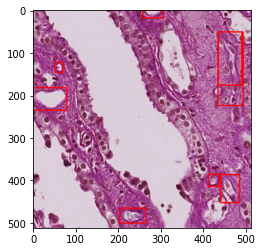

In [2]:
imgs = glob("/Users/macbook/works/vesuvius/data/vasculature/val/*")
img = cv2.imread(random.choice(imgs))
pred = model(img, imgsz=512)[0]
img1=draw_bboxes(img.copy(), pred.boxes.data.cpu().numpy()[:, :4].astype(int))
_=plt.imshow(img1)

In [9]:
from ensemble_boxes import weighted_boxes_fusion, nms
class TileInference:
    """Apply tile inference on single image, det only"""

    def __init__(self, tile=2, ens_box="wbf"):
        self.ens_box = {
            "wbf": weighted_boxes_fusion,
            "nms": nms
        }[ens_box]
        self.grids = make_grid(512, 512, tile)

    def _infer(self, model, img, imgsz=512, conf=0.24, iou=0.7):
        pred = model(img, imgsz=imgsz, conf=conf, iou=iou)[0]
        bboxes = pred.boxes.data.cpu().numpy()[:, :4].astype(int)
        labels = pred.boxes.cls.cpu().numpy().astype(int)
        confs = pred.boxes.conf.cpu().numpy()
        return bboxes, labels, confs

    def __call__(self, model, img,  model_full=None, imgsz=512, conf=0.24, iou=0.7):
        # Model_full, run on full image
        all_boxes = []
        all_labels = []
        all_confs = []
        for i, (x1, x2, y1, y2) in enumerate(self.grids):
            img_cut = img[y1:y2, x1:x2]
            boxes, labels, confs = self._infer(model, img_cut, imgsz=imgsz, conf=conf, iou=iou)
            boxes[:, [0, 2]] += x1  # shift x
            boxes[:, [1, 3]] += y1  # shift y
            all_boxes.append(boxes)
            all_labels.append(labels)
            all_confs.append(confs)
        
        if model_full is not None:
            boxes, labels, confs = self._infer(model, img, imgsz=imgsz, conf=conf, iou=iou)
            all_boxes.append(boxes)
            all_labels.append(labels)
            all_confs.append(confs)

        all_boxes = np.concatenate(all_boxes)
        all_confs = np.concatenate(all_confs)
        all_labels = np.concatenate(all_labels)
        
        keep_idx = non_max_suppression(
            all_boxes,
            all_confs,
            threshold=0.5
        )
        return all_boxes[keep_idx], all_labels[keep_idx], all_confs[keep_idx]

bboxes, labels, confs = TileInference()(model, img, 224)

[ 5  0 12 13 14 15 16]


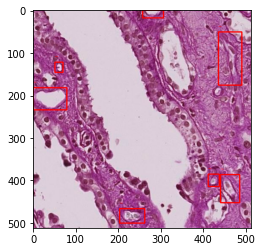

In [10]:
# img2 = draw_bboxes(img.copy(), [(x1,y1,x2,y2) for x1,x2,y1,y2 in make_grid(512, 512, 2)], color=(0, 244,12))
img2 = draw_bboxes(img.copy(), bboxes)
plt.imshow(img2)